# Jeelab mouse body tracking example using U-Net
## - written by 한효빈, HioBeen Han
## - JEELAB, KIST
## - version 2021-04-08b

아래 Repo에서 자료 먼저 받고 시작하시고,

https://gin.g-node.org/hiobeen/Tutorial_of_video_tracking_JEELAB

하다가 모르겠거나 이해 안 가는 부분 있으면 자유롭게 문의하세요! hiobeen.han@kaist.ac.kr / 010-6207-8179

# Part 1. 환경 설정 & 데이터 불러오기

In [ ]:
""" SET ENVIRONMENT """
# Drive mount
from google.colab import auth,drive,files
drive.mount('/content/gdrive')

""" Load modules """
import os, cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt; from matplotlib import cm; plt.style.use('ggplot')
# Download U-net
!pip install git+https://github.com/karolzak/keras-unet
from keras_unet.models import custom_unet

Mounted at /content/gdrive
  Cloning https://github.com/karolzak/keras-unet to /tmp/pip-req-build-mz2kxjun
  Running command git clone -q https://github.com/karolzak/keras-unet /tmp/pip-req-build-mz2kxjun
  Created wheel for keras-unet: filename=keras_unet-0.1.2-cp37-none-any.whl size=16992 sha256=f6143c7754510603006a8608f8ded95e26c1d8dcb325081dce16ab43f9895b25
  Stored in directory: /tmp/pip-ephem-wheel-cache-wzqyrl0j/wheels/b3/3a/85/c3df1c96b5d83dcd2c09b634e72a98cafcf12a52501ac5cd77
Successfully built keras-unet
-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## 여기서부터는 실행 전에 Google drive에 데이터셋을 미리 업로드 해두어야 해요!!!

In [ ]:
""" Google Drive 경로에 파일들 잘 있는지 확인하기 """
# COLAB에서 시스템(리눅스) 명령어 사용은 커맨드 앞에 느낌표(!)를 붙이고 작성
# ls -> listdir의 약자로, directory 내 파일들을 listing 하는 기능을 수행함
# 
!ls gdrive/MyDrive/'Colab Notebooks'/tutorial_data/

frames.zip  trainset.zip


In [ ]:
""" 구글드라이브에 올라간 데이터를 Colab 가상환경으로 복사하기 """
# cp 명령어는 copy의 약자로, cp A B라고 쓰면 A를 B 경로로 복사함.
# cp -r A B 라고 쓰면, A라는 디렉토리 내 파일들을 통째로 B에 복사함.
# 이 예시에서는 tutorial_data/ 폴더 내의 파일들을 content/ 안으로 옮길 것. 
#
!cp -r gdrive/MyDrive/'Colab Notebooks'/tutorial_data/ content/

In [ ]:
""" Zip 파일들 압축 해제하기 """
!unzip content/trainset.zip -d content/
!unzip content/frames.zip -d content/

Archive:  content/trainset.zip
  inflating: content/data/trainset/.DS_Store  
  inflating: content/data/trainset/frame-000007-sample_04-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000024-sample_02-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000035-sample_03-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000038-sample_03-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000042-sample_04-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000056-sample_04-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000069-sample_01-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000083-sample_03-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000084-sample_03-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000089-sample_04-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-0

In [ ]:
""" 이미지 데이터를 Numpy array로 읽어오기 """
data_dir = 'content/data/trainset/'
filename_x = glob( data_dir+'frame*.jpg' ); filename_x.sort()
filename_y = glob( data_dir+'mask*.jpg' );  filename_y.sort()

n_files = len( filename_x )
shape = (448, 448)
x_raw = np.zeros(shape=(n_files,shape[0],shape[1]), dtype='float32')
y_raw = np.zeros(shape=(n_files,shape[0],shape[1]), dtype='bool') # 불리안 타입이 컴퓨팅코스트 측면에서 유리한 타입임
for fileIdx in range(n_files):
  x_raw[fileIdx,] = cv2.imread( filename_x[fileIdx] )[:,:,0]
  y_raw[fileIdx,] = cv2.imread( filename_y[fileIdx] )[:,:,0]>0

In [ ]:
"""  Dataset augmentation """
# 
# 이미지를 가로/세로/가로세로 반전시켜서 4배로 뻥튀기하기
# 
x_aug = np.zeros( (x_raw.shape[0]*4, x_raw.shape[1], x_raw.shape[2] ), dtype='float32')
y_aug = np.zeros( (y_raw.shape[0]*4, y_raw.shape[1], y_raw.shape[2] ), dtype='bool')

imgIdx = 0
for fileIdx in range(x_raw.shape[0]):
  frame, mask = x_raw[fileIdx,], y_raw[fileIdx,]
  frame = frame/255 # 0-1 사이 값으로 스케일링
  # Appending original data
  x_aug[imgIdx,:,:] = frame; y_aug[imgIdx,:,:] = mask; imgIdx+=1
  # Flip x-axis 
  x_aug[imgIdx,:,:] = frame[::-1,:]; y_aug[imgIdx,:,:] = mask[::-1,:]; imgIdx+=1
  # Flip y-axis 
  x_aug[imgIdx,:,:] = frame[:,::-1]; y_aug[imgIdx,:,:] = mask[:,::-1]; imgIdx+=1
  # Flip x & y-axis
  x_aug[imgIdx,:,:] = frame[::-1,::-1]; y_aug[imgIdx,:,:] = mask[::-1,::-1]; imgIdx+=1
print(x_aug.shape)

(400, 448, 448)


Image number 56


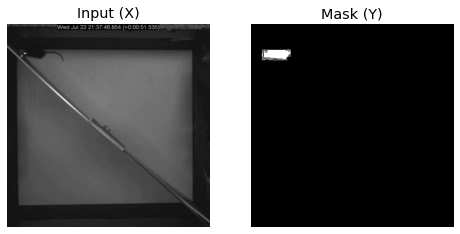

Image number 115


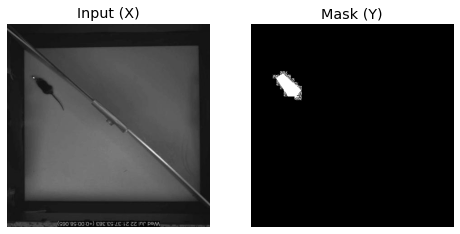

Image number 152


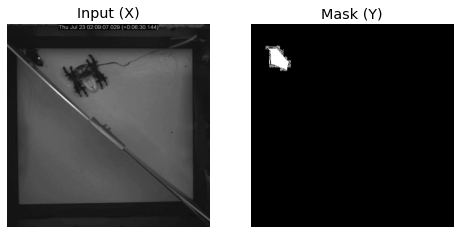

In [ ]:
""" 잘 import 되었는지 확인하기 위한 visualization """
plt.style.use('ggplot')
np.random.seed(20210409)
for fIdx in np.random.randint(0,x_aug.shape[0],3):
  print('Image number %s'%fIdx )
  plt.figure(figsize=(8,4))
  plt.subplot(121); plt.imshow(x_aug[fIdx,:,:],  cmap=cm.gray); plt.axis('off')
  plt.title('Input (X)')
  plt.subplot(122); plt.imshow(y_aug[fIdx,:,:], cmap=cm.gray); plt.axis('off')
  plt.title('Mask (Y)')
  plt.show()

#Part 2. CNN 모델 빌드 & 훈련 진행하기


세부적인 파라미터 튜닝 필요


1.   use_batch_norm => 각 레이어의 입/출력을 0-1 사이로 표준화.
2.   filters => 필터 사이즈 (클수록 sparse하게 봄).
3.   dropout => 랜덤하게 끊을 커넥션의 비율 (0-1).
4.   output_activation => 활성 함수의 종류 (*relu*, *sigmoid*, *tanh*, etc.).
5.   optimizer => *adam*으로 learning_rate = 1e-04 정도면 적당히 빨리 배움 



In [ ]:
""" Train/Test 세트 나누기 """
randseed = 20210408
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    np.expand_dims( x_aug, 3 ), np.expand_dims( y_aug, 3 ),
    test_size=0.1, random_state=np.random.seed(randseed))

print('Training set size => (%d,%d,%d,%d)'%x_train.shape)
print('   Test set size => (%d,%d,%d,%d)'%x_test.shape)

Training set size => (360,448,448,1)
   Test set size => (40,448,448,1)


In [ ]:
""" CNN 네트워크 빌드하기 """
from keras.callbacks import History; 
history = History(); histories = []
from keras import backend as K; import gc
gc.collect(); K.clear_session()
from keras import optimizers

model = custom_unet(input_shape=(shape[0],shape[1],1),
    use_batch_norm=1, num_classes=y_train.shape[-1],
    filters=16, dropout=0.20, output_activation='sigmoid')
metric = 'binary_crossentropy'
model.compile(optimizer = 'Adam', loss = metric, metrics = [metric])
#model.summary()

12/12 - 30s - loss: 0.7318 - binary_crossentropy: 0.7318 - val_loss: 0.6498 - val_binary_crossentropy: 0.6498
Epoch => [~  1] /  50


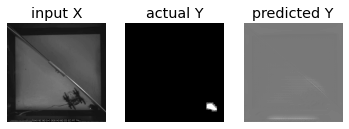

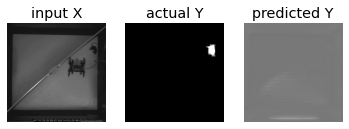

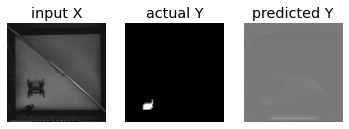

12/12 - 23s - loss: 0.6567 - binary_crossentropy: 0.6567 - val_loss: 0.6541 - val_binary_crossentropy: 0.6541
12/12 - 23s - loss: 0.6184 - binary_crossentropy: 0.6184 - val_loss: 0.6222 - val_binary_crossentropy: 0.6222
12/12 - 23s - loss: 0.5839 - binary_crossentropy: 0.5839 - val_loss: 0.5867 - val_binary_crossentropy: 0.5867
12/12 - 23s - loss: 0.5498 - binary_crossentropy: 0.5498 - val_loss: 0.5397 - val_binary_crossentropy: 0.5397
12/12 - 23s - loss: 0.5151 - binary_crossentropy: 0.5151 - val_loss: 0.4809 - val_binary_crossentropy: 0.4809
12/12 - 23s - loss: 0.4798 - binary_crossentropy: 0.4798 - val_loss: 0.4499 - val_binary_crossentropy: 0.4499
12/12 - 23s - loss: 0.4443 - binary_crossentropy: 0.4443 - val_loss: 0.4051 - val_binary_crossentropy: 0.4051
12/12 - 23s - loss: 0.4089 - binary_crossentropy: 0.4089 - val_loss: 0.3661 - val_binary_crossentropy: 0.3661
12/12 - 23s - loss: 0.3722 - binary_crossentropy: 0.3722 - val_loss: 0.3751 - val_binary_crossentropy: 0.3751
12/12 - 23

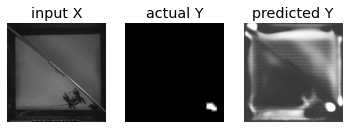

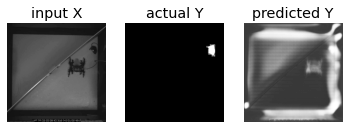

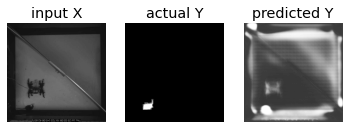

12/12 - 23s - loss: 0.2954 - binary_crossentropy: 0.2954 - val_loss: 0.2254 - val_binary_crossentropy: 0.2254
12/12 - 23s - loss: 0.2572 - binary_crossentropy: 0.2572 - val_loss: 1.5861 - val_binary_crossentropy: 1.5861
12/12 - 23s - loss: 0.2248 - binary_crossentropy: 0.2248 - val_loss: 0.1525 - val_binary_crossentropy: 0.1525
12/12 - 23s - loss: 0.2011 - binary_crossentropy: 0.2011 - val_loss: 0.3351 - val_binary_crossentropy: 0.3351
12/12 - 23s - loss: 0.1800 - binary_crossentropy: 0.1800 - val_loss: 0.4006 - val_binary_crossentropy: 0.4006
12/12 - 23s - loss: 0.1623 - binary_crossentropy: 0.1623 - val_loss: 0.2614 - val_binary_crossentropy: 0.2614
12/12 - 23s - loss: 0.1456 - binary_crossentropy: 0.1456 - val_loss: 0.1140 - val_binary_crossentropy: 0.1140
12/12 - 23s - loss: 0.1320 - binary_crossentropy: 0.1320 - val_loss: 0.1139 - val_binary_crossentropy: 0.1139
12/12 - 23s - loss: 0.1207 - binary_crossentropy: 0.1207 - val_loss: 0.0725 - val_binary_crossentropy: 0.0725
12/12 - 23

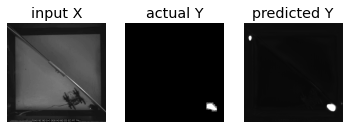

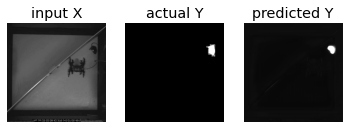

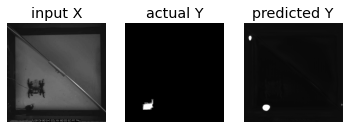

12/12 - 23s - loss: 0.0998 - binary_crossentropy: 0.0998 - val_loss: 0.5262 - val_binary_crossentropy: 0.5262
12/12 - 23s - loss: 0.0914 - binary_crossentropy: 0.0914 - val_loss: 0.4410 - val_binary_crossentropy: 0.4410
12/12 - 23s - loss: 0.0842 - binary_crossentropy: 0.0842 - val_loss: 0.3564 - val_binary_crossentropy: 0.3564
12/12 - 23s - loss: 0.0772 - binary_crossentropy: 0.0772 - val_loss: 0.1535 - val_binary_crossentropy: 0.1535
12/12 - 23s - loss: 0.0715 - binary_crossentropy: 0.0715 - val_loss: 0.0427 - val_binary_crossentropy: 0.0427
12/12 - 23s - loss: 0.0665 - binary_crossentropy: 0.0665 - val_loss: 0.0406 - val_binary_crossentropy: 0.0406
12/12 - 23s - loss: 0.0618 - binary_crossentropy: 0.0618 - val_loss: 0.0390 - val_binary_crossentropy: 0.0390
12/12 - 23s - loss: 0.0573 - binary_crossentropy: 0.0573 - val_loss: 0.0378 - val_binary_crossentropy: 0.0378
12/12 - 23s - loss: 0.0534 - binary_crossentropy: 0.0534 - val_loss: 0.0358 - val_binary_crossentropy: 0.0358
12/12 - 23

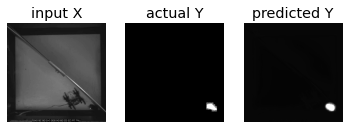

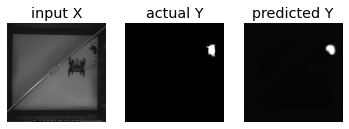

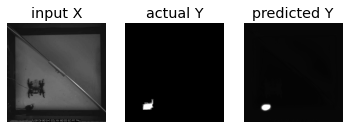

12/12 - 23s - loss: 0.0466 - binary_crossentropy: 0.0466 - val_loss: 0.0325 - val_binary_crossentropy: 0.0325
12/12 - 23s - loss: 0.0438 - binary_crossentropy: 0.0438 - val_loss: 0.0312 - val_binary_crossentropy: 0.0312
12/12 - 23s - loss: 0.0413 - binary_crossentropy: 0.0413 - val_loss: 0.0294 - val_binary_crossentropy: 0.0294
12/12 - 23s - loss: 0.0390 - binary_crossentropy: 0.0390 - val_loss: 0.0288 - val_binary_crossentropy: 0.0288
12/12 - 23s - loss: 0.0367 - binary_crossentropy: 0.0367 - val_loss: 0.0273 - val_binary_crossentropy: 0.0273
12/12 - 23s - loss: 0.0347 - binary_crossentropy: 0.0347 - val_loss: 0.0266 - val_binary_crossentropy: 0.0266
12/12 - 23s - loss: 0.0329 - binary_crossentropy: 0.0329 - val_loss: 0.0258 - val_binary_crossentropy: 0.0258
12/12 - 23s - loss: 0.0313 - binary_crossentropy: 0.0313 - val_loss: 0.0250 - val_binary_crossentropy: 0.0250
12/12 - 23s - loss: 0.0299 - binary_crossentropy: 0.0299 - val_loss: 0.0240 - val_binary_crossentropy: 0.0240
12/12 - 23

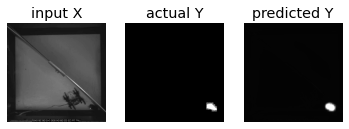

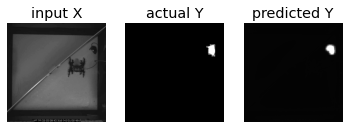

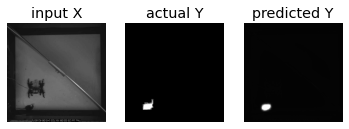

12/12 - 23s - loss: 0.0272 - binary_crossentropy: 0.0272 - val_loss: 0.0234 - val_binary_crossentropy: 0.0234
12/12 - 23s - loss: 0.0260 - binary_crossentropy: 0.0260 - val_loss: 0.0225 - val_binary_crossentropy: 0.0225
12/12 - 23s - loss: 0.0248 - binary_crossentropy: 0.0248 - val_loss: 0.0214 - val_binary_crossentropy: 0.0214
12/12 - 23s - loss: 0.0238 - binary_crossentropy: 0.0238 - val_loss: 0.0209 - val_binary_crossentropy: 0.0209
12/12 - 23s - loss: 0.0228 - binary_crossentropy: 0.0228 - val_loss: 0.0200 - val_binary_crossentropy: 0.0200
12/12 - 23s - loss: 0.0222 - binary_crossentropy: 0.0222 - val_loss: 0.0203 - val_binary_crossentropy: 0.0203
12/12 - 23s - loss: 0.0213 - binary_crossentropy: 0.0213 - val_loss: 0.0196 - val_binary_crossentropy: 0.0196
12/12 - 23s - loss: 0.0204 - binary_crossentropy: 0.0204 - val_loss: 0.0183 - val_binary_crossentropy: 0.0183


In [ ]:
""" Training """
fitIdx, nFit = 1, 50
while fitIdx < nFit:
  history = model.fit(x_train,y_train,epochs=1,verbose=2,batch_size=32, validation_data=(x_test,y_test) )
  
  # Sample visualization
  if np.mod(fitIdx,10)==1:
    print('Epoch => [~%3d] / %3d'%((fitIdx), nFit))
    pred = model.predict(x_test)
    for predIdx in range(3):
      plt.figure(figsize=(6,3))
      plt.subplot(1,3,1); plt.imshow(x_test[predIdx,:,:,0], cmap=cm.gray); plt.axis('off'); plt.title('input X')
      plt.subplot(1,3,2); plt.imshow(y_test[predIdx,:,:,0], cmap=cm.gray); plt.axis('off'); plt.title('actual Y')
      plt.subplot(1,3,3); plt.imshow(pred[predIdx,:,:,0], cmap=cm.gray); plt.axis('off'); plt.title('predicted Y')
      plt.clim(0,1); plt.show()
  fitIdx += 1
 

# Part 3. Non-training frames (Full video) 에 대해 모델 prediction 적용하기

In [ ]:
""" Video frame 읽어온 후 predict 하기 + 그림 파일로 save 하기 """
from datetime import datetime, timedelta
datestr = (datetime.now()+timedelta(hours=9)).strftime("%Y%m%d-%H%M%S")

dir_import = 'content/data/frames/'
dirList = glob(dir_import+'*sample*'); dirList.sort() 
writedir = 'content/data/predicts/'
#!rm -r content/data/predicts/
os.system('mkdir %s'%writedir);
for dirName in dirList:
  print('Now processing [%s]..'%dirName)
  predicts, frames = [], []

  # set directory
  dir_export = writedir+dirName.split('/')[-1]+'/'
  if not os.path.isdir(dir_export): os.mkdir(dir_export)
  
  # Get files
  fileList = glob(dirName+'/frame*.jpg'); fileList.sort()
  for fileName_load in fileList:
    fileName_save = dir_export+'mask'+fileName_load.split('/')[-1][5:]
    exist = len( glob(fileName_save) )>0
    if not exist:
      # Load raw frame
      frame = cv2.imread(fileName_load)[:,:,0]/255
      frame = np.swapaxes(np.expand_dims(np.array(frame),2),0,2)
      # Predict
      pred = np.squeeze(model.predict(frame))
      #plt.imshow(255*pred); plt.show()
      # Save mask
      fileName_save = dir_export+'pred'+fileName_load.split('/')[-1][5:]
      cv2.imwrite(fileName_save,pred*255)
# 저장하기
os.system('zip -r content/predicts-%s.zip content/data/predicts/'%datestr)
files.download('content/predicts-%s.zip'%datestr)

Now processing [content/data/frames/sample_01]..
Now processing [content/data/frames/sample_02]..
Now processing [content/data/frames/sample_03]..
Now processing [content/data/frames/sample_04]..


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
""" 저장하기 """
# 모델 파일 저장하기
model_fname = 'content/model-%s.h5'%datestr
model.save_weights(model_fname)

# 구글드라이브에 백업하기
os.system('zip -r content/predicts-%s.zip content/data/predicts/'%datestr)
os.system("cp content/predicts-%s.zip content/gdrive/MyDrive/'Colab Notebooks'/tutorial_data/"%datestr)
os.system("cp content/model-%s.h5 content/gdrive/MyDrive/'Colab Notebooks'/tutorial_data/"%datestr)

# 로컬 컴퓨터에 다운로드 받기
files.download('content/predicts-%s.zip'%datestr)
#files.download('content/model-%s.h5'%datestr)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>